In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "fsv24"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 147
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0


Numerical Columns: 219
Categorical Columns: 8


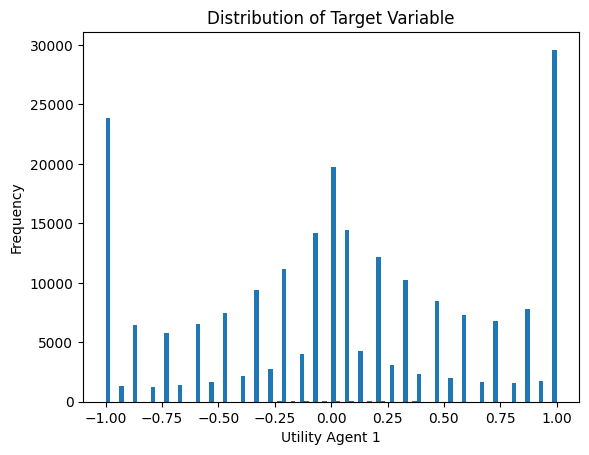

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55312


[100]	val-rmse:0.46292


[200]	val-rmse:0.44598


[300]	val-rmse:0.43897


[400]	val-rmse:0.43406


[500]	val-rmse:0.43099


[600]	val-rmse:0.42905


[700]	val-rmse:0.42775


[800]	val-rmse:0.42698


[900]	val-rmse:0.42626


[1000]	val-rmse:0.42558


[1100]	val-rmse:0.42526


[1200]	val-rmse:0.42490


[1300]	val-rmse:0.42455


[1400]	val-rmse:0.42438


[1500]	val-rmse:0.42419


[1600]	val-rmse:0.42408


[1700]	val-rmse:0.42401


[1800]	val-rmse:0.42397


[1900]	val-rmse:0.42390


[2000]	val-rmse:0.42386


[2100]	val-rmse:0.42387


[2200]	val-rmse:0.42388


[2300]	val-rmse:0.42385


[2400]	val-rmse:0.42375


[2499]	val-rmse:0.42375


Fold 1 - RMSE: 0.4234721129743314
Fold 2


[0]	val-rmse:0.58713


[100]	val-rmse:0.47753


[200]	val-rmse:0.46230


[300]	val-rmse:0.45653


[400]	val-rmse:0.45223


[500]	val-rmse:0.44962


[600]	val-rmse:0.44776


[700]	val-rmse:0.44676


[800]	val-rmse:0.44582


[900]	val-rmse:0.44496


[1000]	val-rmse:0.44433


[1100]	val-rmse:0.44395


[1200]	val-rmse:0.44367


[1300]	val-rmse:0.44337


[1400]	val-rmse:0.44341


[1500]	val-rmse:0.44323


[1600]	val-rmse:0.44300


[1700]	val-rmse:0.44303


[1800]	val-rmse:0.44293


[1900]	val-rmse:0.44288


[2000]	val-rmse:0.44274


[2100]	val-rmse:0.44258


[2200]	val-rmse:0.44248


[2300]	val-rmse:0.44247


[2400]	val-rmse:0.44245


[2499]	val-rmse:0.44238


Fold 2 - RMSE: 0.44209815433873156
Fold 3


[0]	val-rmse:0.60339


[100]	val-rmse:0.46858


[200]	val-rmse:0.44762


[300]	val-rmse:0.43977


[400]	val-rmse:0.43538


[500]	val-rmse:0.43210


[600]	val-rmse:0.42984


[700]	val-rmse:0.42845


[800]	val-rmse:0.42728


[900]	val-rmse:0.42641


[1000]	val-rmse:0.42590


[1100]	val-rmse:0.42553


[1200]	val-rmse:0.42511


[1300]	val-rmse:0.42499


[1400]	val-rmse:0.42479


[1500]	val-rmse:0.42451


[1600]	val-rmse:0.42420


[1700]	val-rmse:0.42397


[1800]	val-rmse:0.42381


[1900]	val-rmse:0.42361


[2000]	val-rmse:0.42356


[2100]	val-rmse:0.42357


[2200]	val-rmse:0.42352


[2300]	val-rmse:0.42350


[2400]	val-rmse:0.42346


[2499]	val-rmse:0.42346


Fold 3 - RMSE: 0.4230269816233628
Fold 4


[0]	val-rmse:0.59486


[100]	val-rmse:0.47632


[200]	val-rmse:0.45814


[300]	val-rmse:0.45069


[400]	val-rmse:0.44544


[500]	val-rmse:0.44177


[600]	val-rmse:0.43993


[700]	val-rmse:0.43862


[800]	val-rmse:0.43752


[900]	val-rmse:0.43658


[1000]	val-rmse:0.43603


[1100]	val-rmse:0.43558


[1200]	val-rmse:0.43523


[1300]	val-rmse:0.43483


[1400]	val-rmse:0.43461


[1500]	val-rmse:0.43445


[1600]	val-rmse:0.43423


[1700]	val-rmse:0.43424


[1800]	val-rmse:0.43418


[1900]	val-rmse:0.43399


[2000]	val-rmse:0.43393


[2100]	val-rmse:0.43381


[2200]	val-rmse:0.43379


[2300]	val-rmse:0.43376


[2400]	val-rmse:0.43367


[2499]	val-rmse:0.43358


Fold 4 - RMSE: 0.43317904686979836
Fold 5


[0]	val-rmse:0.54670


[100]	val-rmse:0.44568


[200]	val-rmse:0.42531


[300]	val-rmse:0.41577


[400]	val-rmse:0.41067


[500]	val-rmse:0.40675


[600]	val-rmse:0.40485


[700]	val-rmse:0.40353


[800]	val-rmse:0.40237


[900]	val-rmse:0.40169


[1000]	val-rmse:0.40095


[1100]	val-rmse:0.40045


[1200]	val-rmse:0.40001


[1300]	val-rmse:0.39967


[1400]	val-rmse:0.39940


[1500]	val-rmse:0.39941


[1600]	val-rmse:0.39927


[1700]	val-rmse:0.39928


[1800]	val-rmse:0.39926


[1900]	val-rmse:0.39918


[2000]	val-rmse:0.39911


[2100]	val-rmse:0.39904


[2200]	val-rmse:0.39899


[2300]	val-rmse:0.39902


[2400]	val-rmse:0.39903


[2499]	val-rmse:0.39910


Fold 5 - RMSE: 0.3987447924184605
List of oof scores: [0.4234721129743314, 0.44209815433873156, 0.4230269816233628, 0.43317904686979836, 0.3987447924184605]
Average oof score: 0.4241042176449369


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53454


[100]	val-rmse:0.44113


[200]	val-rmse:0.42617


[300]	val-rmse:0.41978


[400]	val-rmse:0.41574


[500]	val-rmse:0.41302


[600]	val-rmse:0.41166


[700]	val-rmse:0.41070


[800]	val-rmse:0.40984


[900]	val-rmse:0.40906


[1000]	val-rmse:0.40848


[1100]	val-rmse:0.40805


[1200]	val-rmse:0.40761


[1300]	val-rmse:0.40723


[1400]	val-rmse:0.40710


[1500]	val-rmse:0.40684


[1600]	val-rmse:0.40669


[1700]	val-rmse:0.40654


[1800]	val-rmse:0.40636


[1900]	val-rmse:0.40626


[2000]	val-rmse:0.40619


[2100]	val-rmse:0.40622


[2200]	val-rmse:0.40615


[2300]	val-rmse:0.40612


[2400]	val-rmse:0.40608


[2499]	val-rmse:0.40590


Fold 1 - RMSE: 0.40566236443554526
Fold 2


[0]	val-rmse:0.54493


[100]	val-rmse:0.43186


[200]	val-rmse:0.41738


[300]	val-rmse:0.41223


[400]	val-rmse:0.40911


[500]	val-rmse:0.40718


[600]	val-rmse:0.40621


[700]	val-rmse:0.40542


[800]	val-rmse:0.40504


[900]	val-rmse:0.40484


[1000]	val-rmse:0.40463


[1100]	val-rmse:0.40457


[1200]	val-rmse:0.40473


[1300]	val-rmse:0.40478


[1400]	val-rmse:0.40473


[1500]	val-rmse:0.40479


[1600]	val-rmse:0.40490


[1700]	val-rmse:0.40496


[1800]	val-rmse:0.40514


[1900]	val-rmse:0.40508


[2000]	val-rmse:0.40513


[2100]	val-rmse:0.40526


[2200]	val-rmse:0.40546


[2300]	val-rmse:0.40547


[2400]	val-rmse:0.40565


[2499]	val-rmse:0.40569


Fold 2 - RMSE: 0.4053753534440775
Fold 3


[0]	val-rmse:0.61268


[100]	val-rmse:0.48591


[200]	val-rmse:0.46701


[300]	val-rmse:0.45861


[400]	val-rmse:0.45255


[500]	val-rmse:0.44902


[600]	val-rmse:0.44619


[700]	val-rmse:0.44442


[800]	val-rmse:0.44309


[900]	val-rmse:0.44219


[1000]	val-rmse:0.44127


[1100]	val-rmse:0.44114


[1200]	val-rmse:0.44077


[1300]	val-rmse:0.44033


[1400]	val-rmse:0.43997


[1500]	val-rmse:0.43978


[1600]	val-rmse:0.43954


[1700]	val-rmse:0.43933


[1800]	val-rmse:0.43911


[1900]	val-rmse:0.43900


[2000]	val-rmse:0.43895


[2100]	val-rmse:0.43877


[2200]	val-rmse:0.43851


[2300]	val-rmse:0.43852


[2400]	val-rmse:0.43840


[2499]	val-rmse:0.43837


Fold 3 - RMSE: 0.4379665641915087
Fold 4


[0]	val-rmse:0.60500


[100]	val-rmse:0.48451


[200]	val-rmse:0.46151


[300]	val-rmse:0.45312


[400]	val-rmse:0.44742


[500]	val-rmse:0.44387


[600]	val-rmse:0.44189


[700]	val-rmse:0.44018


[800]	val-rmse:0.43924


[900]	val-rmse:0.43867


[1000]	val-rmse:0.43775


[1100]	val-rmse:0.43747


[1200]	val-rmse:0.43699


[1300]	val-rmse:0.43691


[1400]	val-rmse:0.43672


[1500]	val-rmse:0.43670


[1600]	val-rmse:0.43653


[1700]	val-rmse:0.43626


[1800]	val-rmse:0.43625


[1900]	val-rmse:0.43620


[2000]	val-rmse:0.43605


[2100]	val-rmse:0.43587


[2200]	val-rmse:0.43581


[2300]	val-rmse:0.43593


[2400]	val-rmse:0.43589


[2499]	val-rmse:0.43589


Fold 4 - RMSE: 0.43557281093050226
Fold 5


[0]	val-rmse:0.59006


[100]	val-rmse:0.48146


[200]	val-rmse:0.46224


[300]	val-rmse:0.45315


[400]	val-rmse:0.44709


[500]	val-rmse:0.44328


[600]	val-rmse:0.44043


[700]	val-rmse:0.43876


[800]	val-rmse:0.43751


[900]	val-rmse:0.43672


[1000]	val-rmse:0.43589


[1100]	val-rmse:0.43529


[1200]	val-rmse:0.43481


[1300]	val-rmse:0.43442


[1400]	val-rmse:0.43411


[1500]	val-rmse:0.43386


[1600]	val-rmse:0.43380


[1700]	val-rmse:0.43373


[1800]	val-rmse:0.43362


[1900]	val-rmse:0.43345


[2000]	val-rmse:0.43340


[2100]	val-rmse:0.43343


[2200]	val-rmse:0.43340


[2300]	val-rmse:0.43343


[2400]	val-rmse:0.43351


[2499]	val-rmse:0.43346


Fold 5 - RMSE: 0.4330420951589749
List of oof scores: [0.40566236443554526, 0.4053753534440775, 0.4379665641915087, 0.43557281093050226, 0.4330420951589749]
Average oof score: 0.42352383763212176


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57460


[100]	val-rmse:0.46828


[200]	val-rmse:0.45249


[300]	val-rmse:0.44512


[400]	val-rmse:0.44076


[500]	val-rmse:0.43795


[600]	val-rmse:0.43613


[700]	val-rmse:0.43515


[800]	val-rmse:0.43411


[900]	val-rmse:0.43318


[1000]	val-rmse:0.43287


[1100]	val-rmse:0.43256


[1200]	val-rmse:0.43217


[1300]	val-rmse:0.43190


[1400]	val-rmse:0.43168


[1500]	val-rmse:0.43166


[1600]	val-rmse:0.43150


[1700]	val-rmse:0.43144


[1800]	val-rmse:0.43127


[1900]	val-rmse:0.43112


[2000]	val-rmse:0.43115


[2100]	val-rmse:0.43104


[2200]	val-rmse:0.43111


[2300]	val-rmse:0.43113


[2400]	val-rmse:0.43111


[2499]	val-rmse:0.43104


Fold 1 - RMSE: 0.4307054547583354
Fold 2


[0]	val-rmse:0.57357


[100]	val-rmse:0.46387


[200]	val-rmse:0.44604


[300]	val-rmse:0.43848


[400]	val-rmse:0.43283


[500]	val-rmse:0.42829


[600]	val-rmse:0.42573


[700]	val-rmse:0.42384


[800]	val-rmse:0.42270


[900]	val-rmse:0.42151


[1000]	val-rmse:0.42088


[1100]	val-rmse:0.42028


[1200]	val-rmse:0.41999


[1300]	val-rmse:0.41965


[1400]	val-rmse:0.41927


[1500]	val-rmse:0.41933


[1600]	val-rmse:0.41926


[1700]	val-rmse:0.41914


[1800]	val-rmse:0.41896


[1900]	val-rmse:0.41886


[2000]	val-rmse:0.41884


[2100]	val-rmse:0.41876


[2200]	val-rmse:0.41872


[2300]	val-rmse:0.41877


[2400]	val-rmse:0.41866


[2499]	val-rmse:0.41859


Fold 2 - RMSE: 0.4182933065230539
Fold 3


[0]	val-rmse:0.57579


[100]	val-rmse:0.46462


[200]	val-rmse:0.44789


[300]	val-rmse:0.44168


[400]	val-rmse:0.43763


[500]	val-rmse:0.43486


[600]	val-rmse:0.43297


[700]	val-rmse:0.43198


[800]	val-rmse:0.43091


[900]	val-rmse:0.43038


[1000]	val-rmse:0.42996


[1100]	val-rmse:0.42952


[1200]	val-rmse:0.42919


[1300]	val-rmse:0.42908


[1400]	val-rmse:0.42894


[1500]	val-rmse:0.42884


[1600]	val-rmse:0.42863


[1700]	val-rmse:0.42862


[1800]	val-rmse:0.42848


[1900]	val-rmse:0.42832


[2000]	val-rmse:0.42829


[2100]	val-rmse:0.42825


[2200]	val-rmse:0.42822


[2300]	val-rmse:0.42817


[2400]	val-rmse:0.42816


[2499]	val-rmse:0.42816


Fold 3 - RMSE: 0.4278167832121574
Fold 4


[0]	val-rmse:0.57351


[100]	val-rmse:0.46507


[200]	val-rmse:0.44525


[300]	val-rmse:0.43834


[400]	val-rmse:0.43369


[500]	val-rmse:0.43075


[600]	val-rmse:0.42879


[700]	val-rmse:0.42738


[800]	val-rmse:0.42616


[900]	val-rmse:0.42559


[1000]	val-rmse:0.42488


[1100]	val-rmse:0.42416


[1200]	val-rmse:0.42380


[1300]	val-rmse:0.42352


[1400]	val-rmse:0.42338


[1500]	val-rmse:0.42323


[1600]	val-rmse:0.42310


[1700]	val-rmse:0.42299


[1800]	val-rmse:0.42286


[1900]	val-rmse:0.42281


[2000]	val-rmse:0.42276


[2100]	val-rmse:0.42275


[2200]	val-rmse:0.42260


[2300]	val-rmse:0.42261


[2400]	val-rmse:0.42255


[2499]	val-rmse:0.42253


Fold 4 - RMSE: 0.42225713985230545
Fold 5


[0]	val-rmse:0.58450


[100]	val-rmse:0.46694


[200]	val-rmse:0.44540


[300]	val-rmse:0.43706


[400]	val-rmse:0.43117


[500]	val-rmse:0.42709


[600]	val-rmse:0.42473


[700]	val-rmse:0.42307


[800]	val-rmse:0.42171


[900]	val-rmse:0.42060


[1000]	val-rmse:0.41983


[1100]	val-rmse:0.41938


[1200]	val-rmse:0.41877


[1300]	val-rmse:0.41848


[1400]	val-rmse:0.41821


[1500]	val-rmse:0.41793


[1600]	val-rmse:0.41768


[1700]	val-rmse:0.41748


[1800]	val-rmse:0.41751


[1900]	val-rmse:0.41735


[2000]	val-rmse:0.41735


[2100]	val-rmse:0.41725


[2200]	val-rmse:0.41719


[2300]	val-rmse:0.41728


[2400]	val-rmse:0.41729


[2499]	val-rmse:0.41725


Fold 5 - RMSE: 0.416766880337932
List of oof scores: [0.4307054547583354, 0.4182933065230539, 0.4278167832121574, 0.42225713985230545, 0.416766880337932]
Average oof score: 0.4231679129367568


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4235
Score: 0.4421
Score: 0.4230
Score: 0.4332
Score: 0.3987
Average CV1 Score: 0.4241

CV2 OOF Scores:
Score: 0.4057
Score: 0.4054
Score: 0.4380
Score: 0.4356
Score: 0.4330
Average CV2 Score: 0.4235

CV3 OOF Scores:
Score: 0.4307
Score: 0.4183
Score: 0.4278
Score: 0.4223
Score: 0.4168
Average CV3 Score: 0.4232


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

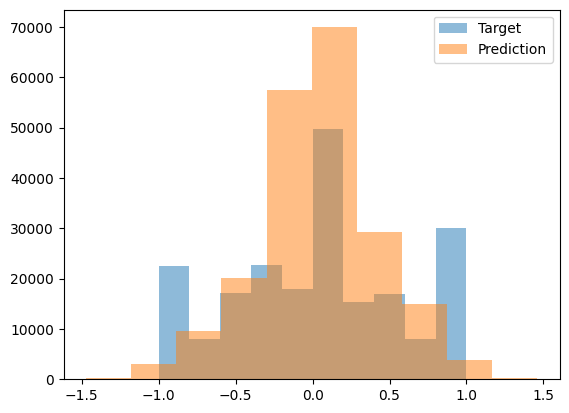

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***